<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/UTKFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTKFace 


In [16]:
# DRIVE MOUNT
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# REPOSITORY CLONE
!git clone https://github.com/Andribi/A2MF_AP.git

Cloning into 'A2MF_AP'...
remote: Enumerating objects: 241781, done.
remote: Counting objects: 100% (46657/46657), done.
remote: Compressing objects: 100% (46649/46649), done.
remote: Total 241781 (delta 46), reused 46590 (delta 8), pack-reused 195124
Receiving objects: 100% (241781/241781), 2.20 GiB | 43.01 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (242756/242756), done.


In [ ]:
# LIBRARIES
!pip install face_recognition

In [5]:
# IMPORTS DATA ANALYSIS
import os 
import json 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import face_recognition
# from face_recognition import face_locations

# MLP IMPORTS
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix

# CNN IMPORTS
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from PIL import Image
from pathlib import Path

In [18]:
# GLOBAL VARS
UTKFACE_DIR = '/content/A2MF_AP/UTKFace/'
UTKFACE_PATH = '/content/A2MF_AP/UTKFace/utkface'
UTKFACE_SK_PATH = '/content/A2MF_AP/UTKFace/utkface_sk'
UTKFACE_LABELS_PATH = '/content/A2MF_AP/UTKFace/utkface.json'
UTKFACE_ATTR_PATH = '/content/A2MF_AP/UTKFace/utkface_attr.json'
UTKFACE_CONFIG_PATH = '/content/A2MF_AP/UTKFace/utkface_config.json'
UTKFACE_FEATURE_CSV_PATH = '/content/A2MF_AP/UTKFace/feature.csv'
UTKFACE_LABEL_CSV_PATH = '/content/A2MF_AP/UTKFace/label.csv'

MODEL_CHKP_CNN_PATH = "/content/drive/MyDrive/AGR_recognition/CNN_face_model"
MODEL_CHKP_MLP_PATH = '/content/drive/MyDrive/AGR_recognition/MLP_face_model.pkl'

ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())
ID_AGE_MAP = {0: 'children', 1: 'young', 2:'adult', 3:'senior', 4:'old'}
AGE_ID_MAP = dict((a, i) for i, a in ID_AGE_MAP.items())

## Data Analysis 

In [19]:
# LABEL CREATION 
'''
This script generates a json file with the labels for the utkface dataset.
The labels of each face image is embedded in the file name, 
formated like [age]_[gender]_[race]_[date&time].jpg
[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting 
White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, 
showing the date and time an image was collected to UTKFace
source: https://susanqq.github.io/UTKFace/
'''

if not UTKFACE_LABELS_PATH:
  res = {}
  print('Creating  labels in utkface.json')
  feat_names = ['age', 'gender', 'race']
  for pic in os.listdir(UTKFACE_PATH):
      features = pic.split('_')[:-1]
      features_dict = {}
      for i in range(len(features)):
          features_dict[feat_names[i]] = int(features[i])
      res[pic] = features_dict
  with open(UTKFACE_LABELS_PATH, 'w') as outfile:
      json.dump(res, outfile)
else:
  print('Labels aready in UTKFace directory')

Labels aready in UTKFace directory


In [20]:
# CREATE DATAFRAME
with open(UTKFACE_LABELS_PATH) as utkface:
    utkface_dict = json.load(utkface)

utkface_df = pd.DataFrame.from_dict(utkface_dict, orient='index')
print('Number of images in UTKFace: ', utkface_df.shape[0])
utkface_df.head(5)

Number of images in UTKFace:  23672


,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,37,0,3.0
15_0_0_20170110225705232.jpg.chip.jpg,15,0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,45,0,3.0
53_0_3_20170119201334485.jpg.chip.jpg,53,0,3.0
22_0_1_20170113193211629.jpg.chip.jpg,22,0,1.0


In [21]:
# MISSING VALUES
print('Percentage of missing values:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')
nan_vals = utkface_df[utkface_df.isna().any(axis=1)]
utkface_df = utkface_df.dropna()
print('Percentage of missing values after drop:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')

print('Number of images in UTKFace after drop: ', utkface_df.shape[0])

Percentage of missing values: 0.01 %
Percentage of missing values after drop: 0.0 %
Number of images in UTKFace after drop:  23669


In [22]:
# AGE CLASSES
utkface_df['race'] = utkface_df['race'].apply(np.int64)
utkface_df.loc[utkface_df.age < 15, 'age'] = 0
utkface_df.loc[((utkface_df.age >= 15) & (utkface_df.age <25)), 'age'] = 1
utkface_df.loc[((utkface_df.age >= 25) & (utkface_df.age <65)), 'age'] = 2
utkface_df.loc[((utkface_df.age >= 65) & (utkface_df.age <85)), 'age'] = 3
utkface_df.loc[utkface_df.age >= 85, 'age'] = 4

# dataframe to use for cnn (recognition)
cnn_df = utkface_df.copy()

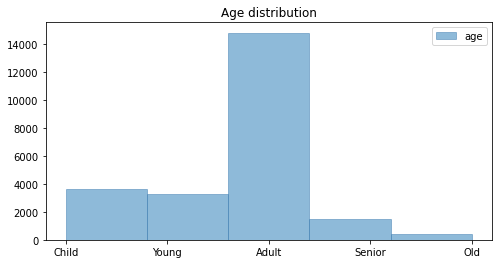

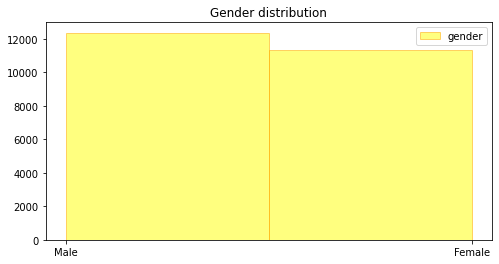

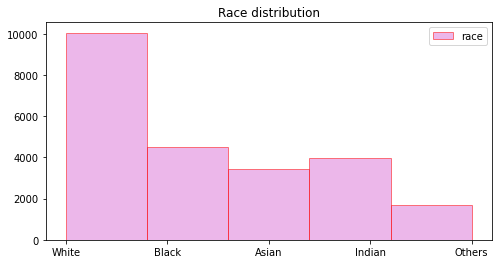

In [23]:
# DISTRIBUTIONS
age = utkface_df["age"].astype(int).sort_values()
age_bins=len(age.value_counts())

gender = utkface_df["gender"].astype(int).sort_values()
gender_bins=len(gender.value_counts())

race = utkface_df["race"].astype(int).sort_values()
race_bins=len(race.value_counts())

age.hist(bins=age_bins, figsize=[8,4], edgecolor='steelblue', 
         linewidth=1, grid=False, alpha=0.5, legend=True)
plt.title('Age distribution')
plt.xticks(np.arange(0, 5, step=1), ['Child', 'Young', 'Adult', 'Senior', 'Old'])
plt.show()

gender.hist(bins=gender_bins, figsize=[8,4], edgecolor='orange', 
            linewidth=1, grid=False, alpha=0.5, legend=True, color='yellow')
plt.title('Gender distribution')
plt.xticks(np.arange(0, 2, step=1), ['Male', 'Female'])
plt.show()

race.hist(bins=race_bins, figsize=[8,4], edgecolor='red', 
          linewidth=1, grid=False, alpha=0.5, legend=True, color='orchid')
plt.xticks(np.arange(0, 5, step=1), ['White', 'Black', 'Asian', 'Indian', 'Others'])
plt.title('Race distribution')
plt.show()

In [24]:
# ONE HOT ENCODING
utkface_df = pd.get_dummies(utkface_df, 
                            columns=["age", "gender", "race"], 
                            dtype=float)
utkface_df.head(5)

,age_0,age_1,age_2,age_3,age_4,gender_0,gender_1,race_0,race_1,race_2,race_3,race_4
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
# ONE HOT ENCODED ATTRIBUTES JSON
attr_dict = utkface_df.to_json(orient='index')
with open(UTKFACE_ATTR_PATH, 'w') as outfile:
    json.dump(json.loads(attr_dict), outfile)

In [26]:
# CSV CREATION 

if not UTKFACE_LABEL_CSV_PATH and not UTKFACE_FEATURE_CSV_PATH:
  vecs = []
  fnames = []
  i = 0
  for fname in tqdm(X_train.index):
      i += 1
      img_path = UTKFACE_PATH + '/' + fname
      X_img = face_recognition.load_image_file(img_path)
      X_faces_loc = face_locations(X_img)
      if len(X_faces_loc) != 1:
          continue
      faces_encoding = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)[0]
      vecs.append(faces_encoding)
      fnames.append(fname)
      
  df_feat = pd.DataFrame(vecs, index=fnames)
  df_label = X_train[X_train.index.isin(df_feat.index)]
  df_feat.sort_index(inplace=True)
  df_label.sort_index(inplace=True)
  df_feat.to_csv(UTKFACE_FEATURE_CSV_PATH)
  df_label.to_csv(UTKFACE_LABEL_CSV_PATH)

else: print('CSVs already present')

CSVs already present


## Age Race Gender Recognition




In [27]:
# DATASET SPLIT
# load features and labels
df_feat = pd.read_csv(UTKFACE_FEATURE_CSV_PATH, index_col=0)
df_label = pd.read_csv(UTKFACE_LABEL_CSV_PATH, index_col=0)
 
# split training/test name
idx_train, idx_test = train_test_split(df_feat.index, test_size = 0.30, random_state = 123)

# train/test for cnns
X_train_cnn = cnn_df.loc[idx_train]
X_test_cnn = cnn_df.loc[idx_test]

# train/test for MLP
X_train_mlp, Y_train_mlp = df_feat.loc[idx_train], df_label.loc[idx_train]
X_test_mlp, Y_test_mlp = df_feat.loc[idx_test], df_label.loc[idx_test]

print('Number of total samples:         ', df_label.shape[0])
print('Number of elements in train set: ', idx_train.shape[0])
print('Number of elements in test set:  ', idx_test.shape[0])

Number of total samples:          14829
Number of elements in train set:  10380
Number of elements in test set:   4449


### Method 1: MLP

Source: https://github.com/wondonghyeon/face-classification/blob/master/train.ipynb

In [14]:
# MLP CLASSIFIER 

if not MODEL_CHKP_MLP_PATH:
  clf = MLPClassifier(solver='adam', 
                      hidden_layer_sizes=(128, 128),
                      max_iter = 5000, 
                      verbose=True, 
                      tol=1e-4, 
                      activation='relu')

  clf.fit(X_train_mlp, Y_train_mlp)

  # save model
  with open(MODEL_CHKP_MLP_PATH, 'wb') as f:
      pickle.dump([clf, df_label.columns.tolist()], f)
      label_list = df_label.columns.tolist()

else:
  clf, label_list = pickle.load(open(MODEL_CHKP_MLP_PATH,'rb'))


# MLP model prediction
pred = clf.predict(X_test_mlp)
score = clf.predict_proba(X_test_mlp)

df_pred = pd.DataFrame(pred, columns=label_list, index=Y_test_mlp.index)
df_score = pd.DataFrame(score, columns=label_list, index=Y_test_mlp.index)

In [15]:
# MLP METRICS
cm_age = confusion_matrix(Y_test_mlp.iloc[:, :5].values.argmax(axis=1), 
                          df_pred.iloc[:, :5].values.argmax(axis=1))
cm_gen = confusion_matrix(Y_test_mlp.iloc[:, 5:7].values.argmax(axis=1), 
                          df_pred.iloc[:, 5:7].values.argmax(axis=1))
cm_race = confusion_matrix(Y_test_mlp.iloc[:, 7:].values.argmax(axis=1), 
                           df_pred.iloc[:, 7:].values.argmax(axis=1))

report = classification_report(Y_test_mlp.values, 
                               df_pred.values, 
                               target_names=Y_test_mlp.columns)

print('CM AGE:\n', cm_age)
print('\nCM GEN:\n', cm_gen)
print('\nCM RACE:\n', cm_race)

print('\nREPORT:\n', report)

CM AGE:
 [[ 641   37   17    0    0]
 [  52  240  314    0    0]
 [  62  256 2377   87    4]
 [  16    3  121  124   22]
 [   7    0    9   34   26]]

CM GEN:
 [[2136  197]
 [ 190 1926]]

CM RACE:
 [[1749   32   21   50   54]
 [  76  676    1   27    9]
 [  46   11  556    8    6]
 [ 136   28    7  586   25]
 [ 184   26   15   54   66]]

REPORT:
               precision    recall  f1-score   support

       age_0       0.94      0.91      0.93       695
       age_1       0.44      0.40      0.42       606
       age_2       0.83      0.86      0.85      2786
       age_3       0.49      0.47      0.48       286
       age_4       0.51      0.46      0.49        76
    gender_0       0.92      0.92      0.92      2333
    gender_1       0.91      0.91      0.91      2116
      race_0       0.85      0.87      0.86      1906
      race_1       0.86      0.87      0.87       789
      race_2       0.91      0.90      0.91       627
      race_3       0.77      0.77      0.77       782
  

### Method 2: CNN

Source: https://github.com/Sobika2531/Age-Gender-And-Race-Detection-Using-CNN/blob/main/AGRdetector.ipynb

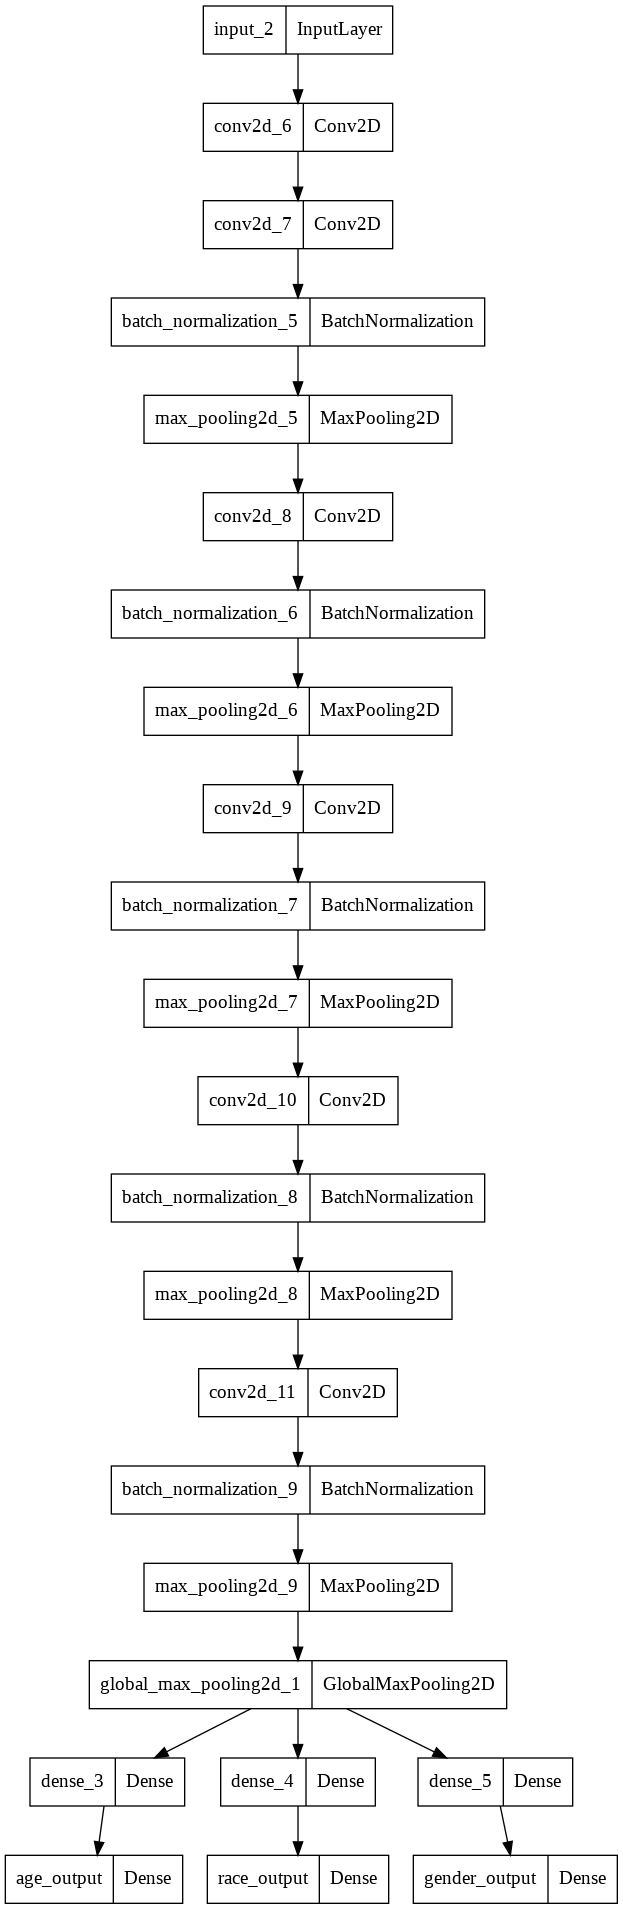

In [28]:
# CNN
def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, 
               kernel_size=3, 
               activation='relu', 
               padding='same')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(200, 200, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=len(AGE_ID_MAP), 
                   activation='softmax', 
                   name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), 
                    activation='softmax', 
                    name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), 
                      activation='softmax', 
                      name='gender_output')(_)

model = Model(inputs=input_layer, 
              outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'categorical_crossentropy', 
                    'race_output': 'categorical_crossentropy', 
                    'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 1, 
                            'race_output': 1, 
                            'gender_output': 1.},
              metrics={'age_output': 'accuracy', 
                       'race_output': 'accuracy', 
                       'gender_output': 'accuracy'})
#model.summary()
plot_model(model, "model.png")

In [29]:
# DATA TO TRAIN

def get_data_generator(df, for_training, batch_size=16):
    images, ages, genders, races = [], [], [], []
    while True:
        for i in range(len(df)):
            r = df.iloc[i]
            file, age, gender, race = r.name, r['age'], r['gender'],  r['race']
            path = Path(UTKFACE_PATH, file)
            im = Image.open(str(path))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age, 5))
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [36]:
# TRAINING

batch_size = 16

# train/val split
X_test_cnn, X_val_cnn = train_test_split(X_test_cnn, test_size = 0.25, random_state = 123)

train_gen = get_data_generator(X_train_cnn, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(X_val_cnn, for_training=True, batch_size=batch_size)
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=batch_size)


callbacks = [ModelCheckpoint(MODEL_CHKP_CNN_PATH, monitor='val_loss')]

history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=len(X_train_cnn)//batch_size,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(X_val_cnn)//batch_size)

Epoch 1/10
  6/648 [..............................] - ETA: 52:32 - loss: 0.6475 - age_output_loss: 0.4305 - race_output_loss: 0.1642 - gender_output_loss: 0.0528 - age_output_accuracy: 0.8333 - race_output_accuracy: 0.9583 - gender_output_accuracy: 0.9896

KeyboardInterrupt: ignored

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [ ]:
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(X_test_cnn)//batch_size)))

In [35]:
x_test, attr_list= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

StopIteration: ignored

In [ ]:
age_true, gender_true, race_true = attr_list[0].argmax(axis=-1), attr_list[1].argmax(axis=-1), attr_list[2].argmax(axis=-1)

age_pred, race_pred, gender_pred = age_pred.argmax(axis=-1), race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

- load dataset
- test
- metriche

###Method 3: ARG (not used now)

Source: https://coursys.sfu.ca/2020sp-cmpt-726-x1/pages/ARG_report/view

REPO: https://github.com/pagand/CMPT726/tree/master/ARG

In [ ]:
! git clone https://github.com/pagand/CMPT726.git

Cloning into 'CMPT726'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 203 (delta 42), reused 2 (delta 1), pack-reused 116
Receiving objects: 100% (203/203), 101.86 KiB | 3.64 MiB/s, done.
Resolving deltas: 100% (91/91), done.


## PGAN

In [16]:
# FACEBOOK PGAN CLONE
!git clone https://github.com/facebookresearch/pytorch_GAN_zoo.git

Cloning into 'pytorch_GAN_zoo'...
remote: Enumerating objects: 1523, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1523 (delta 17), reused 13 (delta 4), pack-reused 1495
Receiving objects: 100% (1523/1523), 2.06 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (977/977), done.


In [17]:
content = { 
    "pathDB": UTKFACE_PATH, 
    "pathAttribDict": UTKFACE_ATTR_PATH,
    "config": {
        "maxIterAtScale": [48000, 96000, 96000, 96000, 96000, 96000, 200000], 
        "depthScales": [256, 256, 256, 128, 64, 32, 16]
        }
    }

with open(UTKFACE_CONFIG_PATH, 'w') as outfile:
    json.dump(content, outfile)

In [ ]:
%cd /content/pytorch_GAN_zoo/
!pip install -r /content/pytorch_GAN_zoo/requirements.txt

/content/pytorch_GAN_zoo
     |████████████████████████████████| 676 kB 5.2 MB/s 
     |████████████████████████████████| 411 kB 41.0 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 269 kB 46.6 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=b8b19b28677abb726bebe77d48ab78858d64224ff006cba0589b94662f7a1771
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=8ed41e95666fe952a50a11f51f2bf8719c39b297f859ba0af05f5e514836d950
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=268b26fa77107cc898c0212c089f90cce9721cfbaa4f6b9df57ed8e0bfdee5aa
  Stored in directory: /root/.cache/pip/whee

In [ ]:
!python train.py --np_vis PGAN -c /content/A2MF_AP/UTKFace/utkface_config.json -n 'utkface_vis' -d /content/drive/MyDrive/checkpoints

Running PGAN
size 10
23669 images found
AC-GAN classes : 
{'age_0': {'order': 0, 'values': [0.0, 1.0]}, 'age_1': {'order': 1, 'values': [0.0, 1.0]}, 'age_2': {'order': 2, 'values': [0.0, 1.0]}, 'age_3': {'order': 3, 'values': [0.0, 1.0]}, 'age_4': {'order': 4, 'values': [0.0, 1.0]}, 'gender_0': {'order': 5, 'values': [0.0, 1.0]}, 'gender_1': {'order': 6, 'values': [0.0, 1.0]}, 'race_0': {'order': 7, 'values': [0.0, 1.0]}, 'race_1': {'order': 8, 'values': [0.0, 1.0]}, 'race_2': {'order': 9, 'values': [0.0, 1.0]}, 'race_3': {'order': 10, 'values': [0.0, 1.0]}, 'race_4': {'order': 11, 'values': [0.0, 1.0]}}

size 10
23669 images found
23669 images detected
size (4, 4)
23669 images found
Changing alpha to 0.000
Traceback (most recent call last):
  File "train.py", line 137, in <module>
    GANTrainer.train()
  File "/content/pytorch_GAN_zoo/models/trainer/progressive_gan_trainer.py", line 237, in train
    maxIter=self.modelConfig.maxIterAtScale[scale])
  File "/content/pytorch_GAN_zoo/mod